In [1]:
import pytest
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import galsim
%pylab inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from learnlets.learnlet_model import Learnlet
from learnlets.keras_utils.normalisation import NormalisationAdjustment
from learnlets.learned_wavelet import learnlet
from tensorflow.keras.optimizers import Adam
from evaluate import keras_psnr, keras_ssim, center_keras_psnr

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print(tf.test.gpu_device_name()) 

Populating the interactive namespace from numpy and matplotlib
runstats and/or skimage could not be imported because not installed
/device:GPU:0


In [2]:
dataset = np.load('datasets/dataset_eigenpsfs.npy',allow_pickle='TRUE').item()

im_train, im_val, target_train, target_val = train_test_split(dataset['VIGNETS_WITH_NOISE'], dataset['VIGNETS_NOISELESS'], 
                                                              shuffle=False, stratify=None, test_size=0.1, random_state=10)

im_train, target_train = shuffle(im_train, target_train)

dataset = np.load('datasets/dataset_gen_train.npy',allow_pickle='TRUE').item()
dataset2 = np.load('datasets/dataset_gen_test.npy',allow_pickle='TRUE').item()

im_train, target_train = dataset['VIGNETS_WITH_NOISE'], dataset['VIGNET_NOISELESS']

im_val, target_val = dataset2['VIGNETS_WITH_NOISE'], dataset2['VIGNET_NOISELESS']

im_train, target_train = shuffle(im_train, target_train)
#im_val, target_val = shuffle(im_val, target_val)

## Calculate the standard deviation and adjust the window function

In [3]:
def mad(x):
    r"""Compute an estimation of the standard deviation 
    of a Gaussian distribution using the robust 
    MAD (Median Absolute Deviation) estimator."""
    return 1.4826*np.median(np.abs(x - np.median(x)))

In [5]:
it_image = 10
image = im_train[it_image,:,:]

In [5]:
my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(image))
star_flux = my_moments.moments_amp
star_flux

GalSimHSMError: Error: too many iterations in adaptive moments


In [6]:
# Calculate window function
obs_centroid = [my_moments.moments_centroid.x, my_moments.moments_centroid.y]
obs_sigma = my_moments.moments_sigma



NameError: name 'my_moments' is not defined

In [6]:
# Draw a window function with the sigma and the centroid

window = np.ones(image.shape, dtype=bool)


for coord_x in range(image.shape[0]):
    for coord_y in range(image.shape[1]):
        
        if np.sqrt((coord_x - 25.5)**2 + (coord_y - 25.5)**2) <= 14 :
            window[coord_x, coord_y] = False
            
mad(image[window])

0.00048464674156003444

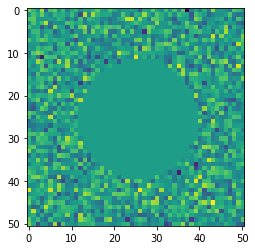

In [7]:
imshow(window*image)

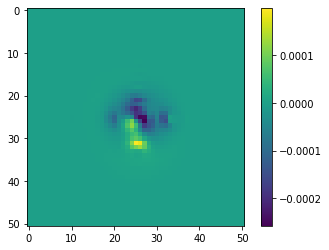

In [8]:
imshow(im_train[208]);colorbar()

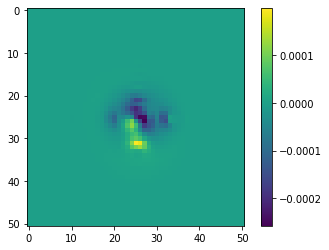

In [9]:
imshow(target_train[208]);colorbar()

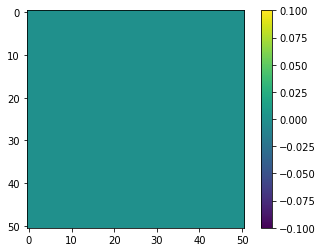

In [10]:
imshow(im_train[208]-target_train[208]);colorbar()

## Preprocessing our images and applying the noise estimator to our training set

We start by normalizing all our dataset to get a L2 norm equal to one. We will then multiply the output of our network by the saved normalization coefficient to retrieve the correct image. We do so to get a better training for our neural network.
Then, we build a noise estimator as it is a required entry for our network. We take a window of the image around the star, and we calculate the noise level on that window.

In [11]:
for i in range (len(im_train)):
    
    norm = np.linalg.norm(im_train[i])
    im_train[i] = im_train[i]/norm
    target_train[i] = target_train[i]/norm
    
    
coeff = np.zeros(len(im_val))    
for i in range (len(im_val)):
    
    coeff[i] = np.linalg.norm(im_val[i])
    im_val[i] = im_val[i]/coeff[i]
    target_val[i] = target_val[i]/coeff[i]

In [12]:
def STD_estimator(image):
        
    # Calculate window function for estimating the noise
    # We take the center of the image and a large radius to cut all the flux from the star
    window = np.ones(image.shape, dtype=bool)
    
    for coord_x in range(image.shape[0]):
        for coord_y in range(image.shape[1]):
            if np.sqrt((coord_x - 25.5)**2 + (coord_y - 25.5)**2) <= 14 :
                window[coord_x, coord_y] = False
    
    # Calculate noise std dev
    noise_std_dev = mad(image[window])
    
    return noise_std_dev

#estimated_STD = np.array([STD_estimator(_im) for _im in im_train])
#for i in range (len(im_train)):
#    std = STD_estimator(im_train[i,:,:])
#    print(i)
#STD_estimator(im_train[14737,:,:])

#estimated_STD = np.array([STD_estimator(im_train[_i,:,:]) for _i in np.arange(2304)])
#estimated_STD = np.append(estimated_STD, 0)
#estimated_STD_2 = np.array([STD_estimator(im_train[_i,:,:]) for _i in np.arange(29047, 36000)])

#estimated_STD = np.concatenate((estimated_STD, estimated_STD_2))

estimated_STD = np.array([STD_estimator(_im) for _im in im_train])

std_val = np.array([STD_estimator(_im) for _im in im_val])


In [13]:
im_train = (tf.reshape(tf.convert_to_tensor(im_train), [len(im_train), 51, 51, 1]))
target_train = tf.reshape(tf.convert_to_tensor(target_train), [len(im_train), 51, 51, 1])
im_val = (tf.reshape(tf.convert_to_tensor(im_val), [len(im_val), 51, 51, 1]))
target_val = tf.reshape(tf.convert_to_tensor(target_val), [len(im_val), 51, 51, 1])

##estimated_STD = (tf.reshape(tf.convert_to_tensor(estimated_STD), [len(im_train), 1]))
##std_val = (tf.reshape(tf.convert_to_tensor(std_val), [len(im_val), 1]))

#estimated_STD = (tf.reshape(tf.convert_to_tensor(np.zeros(20000)), [len(im_train), 1]))
#std_val = (tf.reshape(tf.convert_to_tensor(np.zeros(5000)), [len(im_val), 1]))

In [14]:
## Using Learnlet instead of learnlet
run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 256, 
        'mixing_details': False,    
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}


checkpoint_path = "training_learnlets/cp.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=200*50)

model=Learnlet(**run_params)
n_epochs=1000
model.compile(optimizer=Adam(lr=1e-4),
    loss='mse',
    metrics=[keras_psnr, keras_ssim, center_keras_psnr],
)

history = model.fit(
    (im_train, estimated_STD), 
    target_train,
    validation_data=((im_val, std_val), target_val),
    steps_per_epoch=200, 
    epochs=n_epochs,
    callbacks=[cp_callback],
    batch_size=16,
)

Epoch 1/1000
200/200 [==============================] - 12s 40ms/step - loss: 7.2018e-05 - keras_psnr: 46.3645 - keras_ssim: 0.8956 - center_keras_psnr: 44.5384 - val_loss: 3.4317e-06 - val_keras_psnr: 55.7735 - val_keras_ssim: 0.9922 - val_center_keras_psnr: 53.9380
Epoch 2/1000
200/200 [==============================] - 7s 36ms/step - loss: 3.0777e-06 - keras_psnr: 56.2662 - keras_ssim: 0.9931 - center_keras_psnr: 54.4247 - val_loss: 2.4919e-06 - val_keras_psnr: 57.4180 - val_keras_ssim: 0.9945 - val_center_keras_psnr: 55.5587
Epoch 3/1000
200/200 [==============================] - 7s 36ms/step - loss: 2.3236e-06 - keras_psnr: 57.5761 - keras_ssim: 0.9949 - center_keras_psnr: 55.6937 - val_loss: 2.1983e-06 - val_keras_psnr: 57.8942 - val_keras_ssim: 0.9951 - val_center_keras_psnr: 56.0039
Epoch 4/1000
200/200 [==============================] - 7s 36ms/step - loss: 2.2346e-06 - keras_psnr: 57.8013 - keras_ssim: 0.9952 - center_keras_psnr: 55.8972 - val_loss: 2.0666e-06 - val_keras_psn

Epoch 32/1000
200/200 [==============================] - 7s 36ms/step - loss: 1.0701e-06 - keras_psnr: 60.9861 - keras_ssim: 0.9972 - center_keras_psnr: 59.0475 - val_loss: 1.0863e-06 - val_keras_psnr: 61.0043 - val_keras_ssim: 0.9972 - val_center_keras_psnr: 59.0701
Epoch 33/1000
200/200 [==============================] - 7s 36ms/step - loss: 1.0951e-06 - keras_psnr: 60.8360 - keras_ssim: 0.9972 - center_keras_psnr: 58.9032 - val_loss: 1.0843e-06 - val_keras_psnr: 60.8993 - val_keras_ssim: 0.9972 - val_center_keras_psnr: 58.9913
Epoch 34/1000
200/200 [==============================] - 7s 35ms/step - loss: 1.0764e-06 - keras_psnr: 60.9439 - keras_ssim: 0.9973 - center_keras_psnr: 59.0028 - val_loss: 1.0806e-06 - val_keras_psnr: 60.9175 - val_keras_ssim: 0.9972 - val_center_keras_psnr: 58.9677
Epoch 35/1000
200/200 [==============================] - 7s 36ms/step - loss: 1.0986e-06 - keras_psnr: 60.8687 - keras_ssim: 0.9972 - center_keras_psnr: 58.9382 - val_loss: 1.0757e-06 - val_keras_

Epoch 62/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.6230e-07 - keras_psnr: 61.9057 - keras_ssim: 0.9977 - center_keras_psnr: 59.9470 - val_loss: 8.9208e-07 - val_keras_psnr: 61.8252 - val_keras_ssim: 0.9976 - val_center_keras_psnr: 59.8634
Epoch 63/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.4014e-07 - keras_psnr: 61.9833 - keras_ssim: 0.9977 - center_keras_psnr: 60.0336 - val_loss: 8.7949e-07 - val_keras_psnr: 61.8371 - val_keras_ssim: 0.9975 - val_center_keras_psnr: 59.8823
Epoch 64/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.9103e-07 - keras_psnr: 61.8725 - keras_ssim: 0.9976 - center_keras_psnr: 59.9090 - val_loss: 8.6770e-07 - val_keras_psnr: 61.9511 - val_keras_ssim: 0.9975 - val_center_keras_psnr: 59.9861
Epoch 65/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.7389e-07 - keras_psnr: 61.8966 - keras_ssim: 0.9976 - center_keras_psnr: 59.9338 - val_loss: 8.6749e-07 - val_keras_

200/200 [==============================] - 7s 36ms/step - loss: 7.6975e-07 - keras_psnr: 62.4787 - keras_ssim: 0.9979 - center_keras_psnr: 60.5102 - val_loss: 7.7578e-07 - val_keras_psnr: 62.5075 - val_keras_ssim: 0.9978 - val_center_keras_psnr: 60.5325
Epoch 93/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.1954e-07 - keras_psnr: 62.1985 - keras_ssim: 0.9978 - center_keras_psnr: 60.2103 - val_loss: 8.2195e-07 - val_keras_psnr: 62.0977 - val_keras_ssim: 0.9977 - val_center_keras_psnr: 60.0937
Epoch 94/1000
200/200 [==============================] - 7s 36ms/step - loss: 8.3146e-07 - keras_psnr: 62.1064 - keras_ssim: 0.9978 - center_keras_psnr: 60.1262 - val_loss: 7.6538e-07 - val_keras_psnr: 62.6421 - val_keras_ssim: 0.9979 - val_center_keras_psnr: 60.6925
Epoch 95/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.4858e-07 - keras_psnr: 62.6142 - keras_ssim: 0.9980 - center_keras_psnr: 60.6402 - val_loss: 7.7996e-07 - val_keras_psnr: 62.4903 

Epoch 122/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.0042e-07 - keras_psnr: 62.8341 - keras_ssim: 0.9981 - center_keras_psnr: 60.8516 - val_loss: 7.5953e-07 - val_keras_psnr: 62.5089 - val_keras_ssim: 0.9980 - val_center_keras_psnr: 60.5082
Epoch 123/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.5417e-07 - keras_psnr: 62.5273 - keras_ssim: 0.9980 - center_keras_psnr: 60.5358 - val_loss: 7.5135e-07 - val_keras_psnr: 62.5464 - val_keras_ssim: 0.9979 - val_center_keras_psnr: 60.5483
Epoch 124/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.1719e-07 - keras_psnr: 62.7329 - keras_ssim: 0.9980 - center_keras_psnr: 60.7511 - val_loss: 7.5347e-07 - val_keras_psnr: 62.5263 - val_keras_ssim: 0.9978 - val_center_keras_psnr: 60.5285
Epoch 125/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.9545e-07 - keras_psnr: 62.3065 - keras_ssim: 0.9979 - center_keras_psnr: 60.3134 - val_loss: 7.2785e-07 - val_ke

Epoch 152/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.9148e-07 - keras_psnr: 62.9293 - keras_ssim: 0.9982 - center_keras_psnr: 60.9334 - val_loss: 7.0550e-07 - val_keras_psnr: 62.9484 - val_keras_ssim: 0.9980 - val_center_keras_psnr: 60.9549
Epoch 153/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.9025e-07 - keras_psnr: 62.9417 - keras_ssim: 0.9982 - center_keras_psnr: 60.9495 - val_loss: 7.0944e-07 - val_keras_psnr: 62.8819 - val_keras_ssim: 0.9980 - val_center_keras_psnr: 60.9389
Epoch 154/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.9867e-07 - keras_psnr: 62.8650 - keras_ssim: 0.9981 - center_keras_psnr: 60.8745 - val_loss: 7.0115e-07 - val_keras_psnr: 62.9777 - val_keras_ssim: 0.9981 - val_center_keras_psnr: 60.9931
Epoch 155/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.6787e-07 - keras_psnr: 63.1192 - keras_ssim: 0.9982 - center_keras_psnr: 61.1249 - val_loss: 7.0055e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 6.6860e-07 - keras_psnr: 63.0284 - keras_ssim: 0.9982 - center_keras_psnr: 61.0254 - val_loss: 7.2897e-07 - val_keras_psnr: 62.5828 - val_keras_ssim: 0.9979 - val_center_keras_psnr: 60.5407
Epoch 183/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.5355e-07 - keras_psnr: 63.0299 - keras_ssim: 0.9982 - center_keras_psnr: 61.0320 - val_loss: 6.7232e-07 - val_keras_psnr: 63.3181 - val_keras_ssim: 0.9982 - val_center_keras_psnr: 61.3238
Epoch 184/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.6170e-07 - keras_psnr: 63.1775 - keras_ssim: 0.9982 - center_keras_psnr: 61.1803 - val_loss: 7.0895e-07 - val_keras_psnr: 62.8246 - val_keras_ssim: 0.9982 - val_center_keras_psnr: 60.8109
Epoch 185/1000
200/200 [==============================] - 7s 36ms/step - loss: 7.0050e-07 - keras_psnr: 62.9403 - keras_ssim: 0.9981 - center_keras_psnr: 60.9359 - val_loss: 6.7420e-07 - val_keras_psnr: 63.24

Epoch 212/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.6310e-07 - keras_psnr: 63.0906 - keras_ssim: 0.9982 - center_keras_psnr: 61.0844 - val_loss: 6.7359e-07 - val_keras_psnr: 63.1550 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.1370
Epoch 213/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.6266e-07 - keras_psnr: 63.1404 - keras_ssim: 0.9982 - center_keras_psnr: 61.1424 - val_loss: 6.7853e-07 - val_keras_psnr: 63.0599 - val_keras_ssim: 0.9981 - val_center_keras_psnr: 61.0463
Epoch 214/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4506e-07 - keras_psnr: 63.2160 - keras_ssim: 0.9983 - center_keras_psnr: 61.2024 - val_loss: 6.6797e-07 - val_keras_psnr: 63.2079 - val_keras_ssim: 0.9982 - val_center_keras_psnr: 61.2086
Epoch 215/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.7366e-07 - keras_psnr: 62.9477 - keras_ssim: 0.9982 - center_keras_psnr: 60.9284 - val_loss: 6.5824e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 6.3827e-07 - keras_psnr: 63.3476 - keras_ssim: 0.9983 - center_keras_psnr: 61.3407 - val_loss: 6.6600e-07 - val_keras_psnr: 63.2091 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.1956
Epoch 243/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4073e-07 - keras_psnr: 63.2460 - keras_ssim: 0.9983 - center_keras_psnr: 61.2258 - val_loss: 6.6006e-07 - val_keras_psnr: 63.2770 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.2562
Epoch 244/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.3661e-07 - keras_psnr: 63.3254 - keras_ssim: 0.9984 - center_keras_psnr: 61.3101 - val_loss: 6.4114e-07 - val_keras_psnr: 63.4851 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.4866
Epoch 245/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.3315e-07 - keras_psnr: 63.3051 - keras_ssim: 0.9984 - center_keras_psnr: 61.2894 - val_loss: 6.8029e-07 - val_keras_psnr: 62.98

Epoch 272/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4418e-07 - keras_psnr: 63.3269 - keras_ssim: 0.9983 - center_keras_psnr: 61.3164 - val_loss: 6.6296e-07 - val_keras_psnr: 63.1858 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.1574
Epoch 273/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4479e-07 - keras_psnr: 63.2129 - keras_ssim: 0.9983 - center_keras_psnr: 61.1931 - val_loss: 6.5169e-07 - val_keras_psnr: 63.3019 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.2889
Epoch 274/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.5263e-07 - keras_psnr: 63.1909 - keras_ssim: 0.9983 - center_keras_psnr: 61.1758 - val_loss: 6.4029e-07 - val_keras_psnr: 63.4151 - val_keras_ssim: 0.9982 - val_center_keras_psnr: 61.4022
Epoch 275/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.3944e-07 - keras_psnr: 63.3008 - keras_ssim: 0.9983 - center_keras_psnr: 61.2760 - val_loss: 6.3892e-07 - val_ke

Epoch 302/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4563e-07 - keras_psnr: 63.3007 - keras_ssim: 0.9983 - center_keras_psnr: 61.2888 - val_loss: 6.3064e-07 - val_keras_psnr: 63.5178 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.5088
Epoch 303/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.3218e-07 - keras_psnr: 63.3778 - keras_ssim: 0.9983 - center_keras_psnr: 61.3510 - val_loss: 6.5030e-07 - val_keras_psnr: 63.2811 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.2785
Epoch 304/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.1274e-07 - keras_psnr: 63.4539 - keras_ssim: 0.9984 - center_keras_psnr: 61.4317 - val_loss: 6.3210e-07 - val_keras_psnr: 63.5477 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.5299
Epoch 305/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4608e-07 - keras_psnr: 63.2616 - keras_ssim: 0.9984 - center_keras_psnr: 61.2420 - val_loss: 6.4485e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 6.3711e-07 - keras_psnr: 63.3667 - keras_ssim: 0.9983 - center_keras_psnr: 61.3562 - val_loss: 6.2482e-07 - val_keras_psnr: 63.6145 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.6081
Epoch 333/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0239e-07 - keras_psnr: 63.4767 - keras_ssim: 0.9984 - center_keras_psnr: 61.4478 - val_loss: 6.5191e-07 - val_keras_psnr: 63.2277 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.1747
Epoch 334/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.1743e-07 - keras_psnr: 63.4354 - keras_ssim: 0.9984 - center_keras_psnr: 61.4083 - val_loss: 6.2972e-07 - val_keras_psnr: 63.4894 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.4674
Epoch 335/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0680e-07 - keras_psnr: 63.5162 - keras_ssim: 0.9984 - center_keras_psnr: 61.4885 - val_loss: 6.2487e-07 - val_keras_psnr: 63.49

Epoch 362/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.7156e-07 - keras_psnr: 63.0986 - keras_ssim: 0.9983 - center_keras_psnr: 61.0702 - val_loss: 6.2231e-07 - val_keras_psnr: 63.5229 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.4983
Epoch 363/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4383e-07 - keras_psnr: 63.3852 - keras_ssim: 0.9983 - center_keras_psnr: 61.3551 - val_loss: 6.3755e-07 - val_keras_psnr: 63.3652 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.3342
Epoch 364/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8399e-07 - keras_psnr: 63.6122 - keras_ssim: 0.9985 - center_keras_psnr: 61.5882 - val_loss: 6.3908e-07 - val_keras_psnr: 63.3458 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.3127
Epoch 365/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4338e-07 - keras_psnr: 63.2899 - keras_ssim: 0.9984 - center_keras_psnr: 61.2507 - val_loss: 6.3973e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 6.1711e-07 - keras_psnr: 63.4550 - keras_ssim: 0.9984 - center_keras_psnr: 61.4180 - val_loss: 6.2394e-07 - val_keras_psnr: 63.4455 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.4313
Epoch 393/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9359e-07 - keras_psnr: 63.6020 - keras_ssim: 0.9985 - center_keras_psnr: 61.5761 - val_loss: 6.1917e-07 - val_keras_psnr: 63.5843 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.5633
Epoch 394/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9802e-07 - keras_psnr: 63.6369 - keras_ssim: 0.9985 - center_keras_psnr: 61.6047 - val_loss: 6.3342e-07 - val_keras_psnr: 63.3791 - val_keras_ssim: 0.9983 - val_center_keras_psnr: 61.3789
Epoch 395/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.4495e-07 - keras_psnr: 63.2657 - keras_ssim: 0.9983 - center_keras_psnr: 61.2389 - val_loss: 6.0709e-07 - val_keras_psnr: 63.76

Epoch 422/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0091e-07 - keras_psnr: 63.6095 - keras_ssim: 0.9985 - center_keras_psnr: 61.5597 - val_loss: 6.2781e-07 - val_keras_psnr: 63.4310 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.4198
Epoch 423/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0966e-07 - keras_psnr: 63.5326 - keras_ssim: 0.9984 - center_keras_psnr: 61.5037 - val_loss: 6.2602e-07 - val_keras_psnr: 63.4684 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.4247
Epoch 424/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0090e-07 - keras_psnr: 63.5053 - keras_ssim: 0.9985 - center_keras_psnr: 61.4624 - val_loss: 6.2552e-07 - val_keras_psnr: 63.4854 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.4331
Epoch 425/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9842e-07 - keras_psnr: 63.5741 - keras_ssim: 0.9985 - center_keras_psnr: 61.5410 - val_loss: 6.2908e-07 - val_ke

Epoch 452/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0067e-07 - keras_psnr: 63.6023 - keras_ssim: 0.9985 - center_keras_psnr: 61.5686 - val_loss: 6.0877e-07 - val_keras_psnr: 63.6407 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6073
Epoch 453/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9716e-07 - keras_psnr: 63.6910 - keras_ssim: 0.9985 - center_keras_psnr: 61.6526 - val_loss: 6.1109e-07 - val_keras_psnr: 63.6662 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6224
Epoch 454/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.2105e-07 - keras_psnr: 63.4493 - keras_ssim: 0.9984 - center_keras_psnr: 61.4077 - val_loss: 6.0247e-07 - val_keras_psnr: 63.7611 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.7335
Epoch 455/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0444e-07 - keras_psnr: 63.5421 - keras_ssim: 0.9985 - center_keras_psnr: 61.4978 - val_loss: 5.9612e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.9055e-07 - keras_psnr: 63.6473 - keras_ssim: 0.9985 - center_keras_psnr: 61.6123 - val_loss: 6.1402e-07 - val_keras_psnr: 63.5921 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.5395
Epoch 483/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7829e-07 - keras_psnr: 63.7018 - keras_ssim: 0.9985 - center_keras_psnr: 61.6631 - val_loss: 6.1811e-07 - val_keras_psnr: 63.5103 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.4790
Epoch 484/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8136e-07 - keras_psnr: 63.6868 - keras_ssim: 0.9985 - center_keras_psnr: 61.6525 - val_loss: 5.9236e-07 - val_keras_psnr: 63.8481 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8306
Epoch 485/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7982e-07 - keras_psnr: 63.7336 - keras_ssim: 0.9985 - center_keras_psnr: 61.6978 - val_loss: 6.1712e-07 - val_keras_psnr: 63.48

Epoch 512/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8850e-07 - keras_psnr: 63.6300 - keras_ssim: 0.9985 - center_keras_psnr: 61.5819 - val_loss: 6.0313e-07 - val_keras_psnr: 63.6580 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6166
Epoch 513/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8840e-07 - keras_psnr: 63.6553 - keras_ssim: 0.9985 - center_keras_psnr: 61.6105 - val_loss: 5.8231e-07 - val_keras_psnr: 63.9985 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9761
Epoch 514/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9621e-07 - keras_psnr: 63.6464 - keras_ssim: 0.9985 - center_keras_psnr: 61.6086 - val_loss: 6.5043e-07 - val_keras_psnr: 63.0497 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 60.9784
Epoch 515/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.1064e-07 - keras_psnr: 63.5175 - keras_ssim: 0.9985 - center_keras_psnr: 61.4655 - val_loss: 6.1872e-07 - val_ke

200/200 [==============================] - 7s 35ms/step - loss: 6.0514e-07 - keras_psnr: 63.5958 - keras_ssim: 0.9985 - center_keras_psnr: 61.5542 - val_loss: 5.9846e-07 - val_keras_psnr: 63.7197 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6816
Epoch 543/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.6698e-07 - keras_psnr: 63.8058 - keras_ssim: 0.9985 - center_keras_psnr: 61.7604 - val_loss: 6.1518e-07 - val_keras_psnr: 63.5324 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.4776
Epoch 544/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.8455e-07 - keras_psnr: 63.6125 - keras_ssim: 0.9985 - center_keras_psnr: 61.5646 - val_loss: 6.0202e-07 - val_keras_psnr: 63.6730 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.6388
Epoch 545/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.7616e-07 - keras_psnr: 63.7368 - keras_ssim: 0.9985 - center_keras_psnr: 61.6932 - val_loss: 5.9363e-07 - val_keras_psnr: 63.76

Epoch 572/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.8770e-07 - keras_psnr: 63.6256 - keras_ssim: 0.9985 - center_keras_psnr: 61.5675 - val_loss: 5.7701e-07 - val_keras_psnr: 64.0059 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9662
Epoch 573/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.8008e-07 - keras_psnr: 63.8330 - keras_ssim: 0.9986 - center_keras_psnr: 61.7997 - val_loss: 5.8495e-07 - val_keras_psnr: 63.8645 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8251
Epoch 574/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6231e-07 - keras_psnr: 63.8700 - keras_ssim: 0.9986 - center_keras_psnr: 61.8245 - val_loss: 6.1989e-07 - val_keras_psnr: 63.3759 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.3159
Epoch 575/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6440e-07 - keras_psnr: 63.8527 - keras_ssim: 0.9986 - center_keras_psnr: 61.8031 - val_loss: 6.0433e-07 - val_ke

Epoch 602/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7553e-07 - keras_psnr: 63.8017 - keras_ssim: 0.9986 - center_keras_psnr: 61.7555 - val_loss: 5.8343e-07 - val_keras_psnr: 63.8980 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8747
Epoch 603/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8455e-07 - keras_psnr: 63.7624 - keras_ssim: 0.9985 - center_keras_psnr: 61.7099 - val_loss: 5.8398e-07 - val_keras_psnr: 63.8840 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8477
Epoch 604/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.6847e-07 - keras_psnr: 63.8987 - keras_ssim: 0.9986 - center_keras_psnr: 61.8587 - val_loss: 5.9649e-07 - val_keras_psnr: 63.7225 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.7026
Epoch 605/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9584e-07 - keras_psnr: 63.5244 - keras_ssim: 0.9985 - center_keras_psnr: 61.4860 - val_loss: 5.9384e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.6053e-07 - keras_psnr: 63.7099 - keras_ssim: 0.9986 - center_keras_psnr: 61.6560 - val_loss: 5.9774e-07 - val_keras_psnr: 63.6428 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.5930
Epoch 633/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6971e-07 - keras_psnr: 63.9144 - keras_ssim: 0.9986 - center_keras_psnr: 61.8682 - val_loss: 5.8226e-07 - val_keras_psnr: 63.8788 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8430
Epoch 634/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9694e-07 - keras_psnr: 63.7022 - keras_ssim: 0.9985 - center_keras_psnr: 61.6759 - val_loss: 5.9716e-07 - val_keras_psnr: 63.6863 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6338
Epoch 635/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6826e-07 - keras_psnr: 63.8402 - keras_ssim: 0.9986 - center_keras_psnr: 61.8015 - val_loss: 6.1388e-07 - val_keras_psnr: 63.49

Epoch 662/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6834e-07 - keras_psnr: 63.8284 - keras_ssim: 0.9986 - center_keras_psnr: 61.7814 - val_loss: 6.2362e-07 - val_keras_psnr: 63.3024 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.2329
Epoch 663/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.8914e-07 - keras_psnr: 63.6998 - keras_ssim: 0.9985 - center_keras_psnr: 61.6618 - val_loss: 6.0037e-07 - val_keras_psnr: 63.6362 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.5779
Epoch 664/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6330e-07 - keras_psnr: 63.8615 - keras_ssim: 0.9986 - center_keras_psnr: 61.8130 - val_loss: 5.8928e-07 - val_keras_psnr: 63.7735 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.7253
Epoch 665/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7108e-07 - keras_psnr: 63.8609 - keras_ssim: 0.9986 - center_keras_psnr: 61.8145 - val_loss: 5.9769e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.7803e-07 - keras_psnr: 63.7297 - keras_ssim: 0.9986 - center_keras_psnr: 61.6789 - val_loss: 5.8588e-07 - val_keras_psnr: 63.8082 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8071
Epoch 693/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6231e-07 - keras_psnr: 63.8840 - keras_ssim: 0.9986 - center_keras_psnr: 61.8390 - val_loss: 5.7299e-07 - val_keras_psnr: 63.9605 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9202
Epoch 694/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5559e-07 - keras_psnr: 63.9415 - keras_ssim: 0.9986 - center_keras_psnr: 61.8913 - val_loss: 5.8252e-07 - val_keras_psnr: 63.8999 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.8589
Epoch 695/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5949e-07 - keras_psnr: 63.9438 - keras_ssim: 0.9986 - center_keras_psnr: 61.8979 - val_loss: 5.8083e-07 - val_keras_psnr: 63.88

Epoch 722/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6829e-07 - keras_psnr: 63.8580 - keras_ssim: 0.9986 - center_keras_psnr: 61.8008 - val_loss: 5.8748e-07 - val_keras_psnr: 63.7394 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.6927
Epoch 723/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.9547e-07 - keras_psnr: 63.7344 - keras_ssim: 0.9985 - center_keras_psnr: 61.6919 - val_loss: 5.7439e-07 - val_keras_psnr: 63.9516 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.8957
Epoch 724/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5048e-07 - keras_psnr: 63.9010 - keras_ssim: 0.9986 - center_keras_psnr: 61.8462 - val_loss: 5.6972e-07 - val_keras_psnr: 64.0158 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 62.0033
Epoch 725/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4185e-07 - keras_psnr: 64.0490 - keras_ssim: 0.9986 - center_keras_psnr: 62.0099 - val_loss: 5.6687e-07 - val_ke

Epoch 752/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7022e-07 - keras_psnr: 63.8048 - keras_ssim: 0.9986 - center_keras_psnr: 61.7527 - val_loss: 5.9903e-07 - val_keras_psnr: 63.6036 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.5604
Epoch 753/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6838e-07 - keras_psnr: 63.8312 - keras_ssim: 0.9986 - center_keras_psnr: 61.7900 - val_loss: 5.8248e-07 - val_keras_psnr: 63.8280 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.7827
Epoch 754/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7907e-07 - keras_psnr: 63.7761 - keras_ssim: 0.9986 - center_keras_psnr: 61.7229 - val_loss: 5.7814e-07 - val_keras_psnr: 63.9216 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8661
Epoch 755/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4668e-07 - keras_psnr: 64.0240 - keras_ssim: 0.9986 - center_keras_psnr: 61.9813 - val_loss: 5.7697e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.5365e-07 - keras_psnr: 63.9159 - keras_ssim: 0.9986 - center_keras_psnr: 61.8681 - val_loss: 5.8894e-07 - val_keras_psnr: 63.7567 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.7015
Epoch 783/1000
200/200 [==============================] - 7s 36ms/step - loss: 6.0587e-07 - keras_psnr: 63.5333 - keras_ssim: 0.9985 - center_keras_psnr: 61.4787 - val_loss: 5.8037e-07 - val_keras_psnr: 63.8689 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.8143
Epoch 784/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6517e-07 - keras_psnr: 63.8919 - keras_ssim: 0.9986 - center_keras_psnr: 61.8366 - val_loss: 5.7032e-07 - val_keras_psnr: 63.9854 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9504
Epoch 785/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4772e-07 - keras_psnr: 63.9424 - keras_ssim: 0.9987 - center_keras_psnr: 61.8873 - val_loss: 5.6037e-07 - val_keras_psnr: 64.12

Epoch 812/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4312e-07 - keras_psnr: 63.9661 - keras_ssim: 0.9986 - center_keras_psnr: 61.9268 - val_loss: 5.6941e-07 - val_keras_psnr: 63.9954 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9486
Epoch 813/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6809e-07 - keras_psnr: 63.8851 - keras_ssim: 0.9986 - center_keras_psnr: 61.8337 - val_loss: 5.6116e-07 - val_keras_psnr: 64.0662 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 62.0230
Epoch 814/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6987e-07 - keras_psnr: 63.8870 - keras_ssim: 0.9986 - center_keras_psnr: 61.8335 - val_loss: 5.7094e-07 - val_keras_psnr: 63.9506 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8956
Epoch 815/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6391e-07 - keras_psnr: 63.8487 - keras_ssim: 0.9986 - center_keras_psnr: 61.7918 - val_loss: 5.6380e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.9420e-07 - keras_psnr: 63.7048 - keras_ssim: 0.9986 - center_keras_psnr: 61.6581 - val_loss: 5.8682e-07 - val_keras_psnr: 63.7157 - val_keras_ssim: 0.9984 - val_center_keras_psnr: 61.6700
Epoch 843/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.7383e-07 - keras_psnr: 63.7856 - keras_ssim: 0.9985 - center_keras_psnr: 61.7370 - val_loss: 5.6030e-07 - val_keras_psnr: 64.0789 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 62.0500
Epoch 844/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5549e-07 - keras_psnr: 63.9938 - keras_ssim: 0.9986 - center_keras_psnr: 61.9403 - val_loss: 5.7082e-07 - val_keras_psnr: 63.9735 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9172
Epoch 845/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.3816e-07 - keras_psnr: 64.1044 - keras_ssim: 0.9987 - center_keras_psnr: 62.0571 - val_loss: 6.0274e-07 - val_keras_psnr: 63.56

Epoch 872/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4088e-07 - keras_psnr: 64.0635 - keras_ssim: 0.9986 - center_keras_psnr: 62.0244 - val_loss: 5.8105e-07 - val_keras_psnr: 63.7938 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.7408
Epoch 873/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5259e-07 - keras_psnr: 63.9397 - keras_ssim: 0.9986 - center_keras_psnr: 61.8769 - val_loss: 5.7318e-07 - val_keras_psnr: 63.8897 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8283
Epoch 874/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4650e-07 - keras_psnr: 64.0919 - keras_ssim: 0.9986 - center_keras_psnr: 62.0258 - val_loss: 5.6626e-07 - val_keras_psnr: 64.0607 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.0094
Epoch 875/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4726e-07 - keras_psnr: 63.9480 - keras_ssim: 0.9986 - center_keras_psnr: 61.9015 - val_loss: 5.6676e-07 - val_ke

Epoch 902/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.4817e-07 - keras_psnr: 64.0331 - keras_ssim: 0.9986 - center_keras_psnr: 61.9833 - val_loss: 5.9268e-07 - val_keras_psnr: 63.5991 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.5285
Epoch 903/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.6007e-07 - keras_psnr: 63.7762 - keras_ssim: 0.9986 - center_keras_psnr: 61.7115 - val_loss: 5.9261e-07 - val_keras_psnr: 63.5904 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.5083
Epoch 904/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.3893e-07 - keras_psnr: 64.0078 - keras_ssim: 0.9987 - center_keras_psnr: 61.9554 - val_loss: 5.6145e-07 - val_keras_psnr: 64.0657 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.0447
Epoch 905/1000
200/200 [==============================] - 7s 35ms/step - loss: 5.7788e-07 - keras_psnr: 63.7955 - keras_ssim: 0.9986 - center_keras_psnr: 61.7483 - val_loss: 5.5488e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.6667e-07 - keras_psnr: 63.9378 - keras_ssim: 0.9986 - center_keras_psnr: 61.8832 - val_loss: 5.5153e-07 - val_keras_psnr: 64.2391 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.2052
Epoch 933/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4542e-07 - keras_psnr: 64.1256 - keras_ssim: 0.9986 - center_keras_psnr: 62.0851 - val_loss: 5.7391e-07 - val_keras_psnr: 63.8692 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.8130
Epoch 934/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.3933e-07 - keras_psnr: 64.0655 - keras_ssim: 0.9987 - center_keras_psnr: 62.0112 - val_loss: 5.6423e-07 - val_keras_psnr: 64.0110 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9541
Epoch 935/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.2962e-07 - keras_psnr: 64.1719 - keras_ssim: 0.9987 - center_keras_psnr: 62.1310 - val_loss: 5.8294e-07 - val_keras_psnr: 63.66

Epoch 962/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6253e-07 - keras_psnr: 63.9491 - keras_ssim: 0.9986 - center_keras_psnr: 61.8946 - val_loss: 5.4748e-07 - val_keras_psnr: 64.2648 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.2204
Epoch 963/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.3769e-07 - keras_psnr: 64.0545 - keras_ssim: 0.9987 - center_keras_psnr: 62.0000 - val_loss: 5.5901e-07 - val_keras_psnr: 64.1099 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.0614
Epoch 964/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.2037e-07 - keras_psnr: 64.1925 - keras_ssim: 0.9987 - center_keras_psnr: 62.1450 - val_loss: 5.6147e-07 - val_keras_psnr: 64.0533 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 61.9850
Epoch 965/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.5420e-07 - keras_psnr: 63.9605 - keras_ssim: 0.9986 - center_keras_psnr: 61.9131 - val_loss: 5.6570e-07 - val_ke

200/200 [==============================] - 7s 36ms/step - loss: 5.3291e-07 - keras_psnr: 64.0484 - keras_ssim: 0.9987 - center_keras_psnr: 61.9922 - val_loss: 5.4379e-07 - val_keras_psnr: 64.3157 - val_keras_ssim: 0.9986 - val_center_keras_psnr: 62.2739
Epoch 993/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4856e-07 - keras_psnr: 64.0542 - keras_ssim: 0.9986 - center_keras_psnr: 62.0036 - val_loss: 5.9519e-07 - val_keras_psnr: 63.5156 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.4498
Epoch 994/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.4525e-07 - keras_psnr: 63.9971 - keras_ssim: 0.9987 - center_keras_psnr: 61.9432 - val_loss: 5.5952e-07 - val_keras_psnr: 63.9879 - val_keras_ssim: 0.9985 - val_center_keras_psnr: 61.9350
Epoch 995/1000
200/200 [==============================] - 7s 36ms/step - loss: 5.6974e-07 - keras_psnr: 63.7574 - keras_ssim: 0.9986 - center_keras_psnr: 61.7003 - val_loss: 5.5982e-07 - val_keras_psnr: 64.07

Model: "learnlet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learnlet_analysis (LearnletA multiple                  32025     
_________________________________________________________________
scales_threshold (ScalesThre multiple                  1290      
_________________________________________________________________
learnlet_synthesis (Learnlet multiple                  32125     
Total params: 65,440
Trainable params: 64,130
Non-trainable params: 1,310
_________________________________________________________________
None


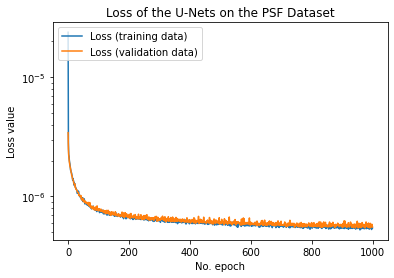

In [15]:
print(model.summary())
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss of the U-Nets on the PSF Dataset')
plt.ylabel('Loss value')
plt.yscale('log')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Validation du modèle

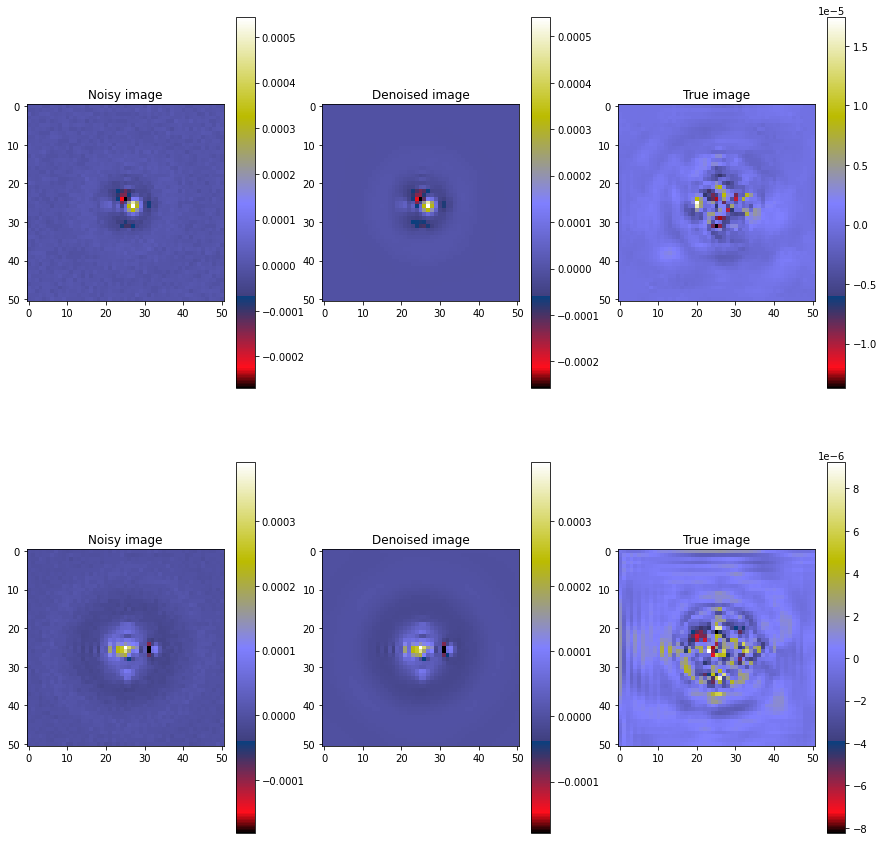

In [16]:
ind = 132
deud = 400

one_star_noiseless = tf.reshape(model.predict((im_val, std_val))[ind,:,:], [51, 51])*coeff[ind]
one_star_truth = tf.reshape(tf.convert_to_tensor(target_val[ind,:,:]), [51, 51])*coeff[ind]
one_star_noiseless = tf.cast(one_star_noiseless, one_star_truth.dtype)
one_star_noise = tf.reshape(tf.convert_to_tensor(im_val[ind,:,:]), [51, 51])*coeff[ind]
second_star_noiseless = tf.reshape(model.predict((im_val, std_val))[deud,:,:], [51, 51])*coeff[deud]
second_star_truth = tf.reshape(tf.convert_to_tensor(target_val[deud,:,:]), [51, 51])*coeff[deud]
second_star_noiseless = tf.cast(second_star_noiseless, second_star_truth.dtype)
second_star_noise = tf.reshape(tf.convert_to_tensor(im_val[deud,:,:]), [51, 51])*coeff[deud]



fig = plt.figure(num=0, figsize=(15,15))
subplot(231)
title('Noisy image')
imshow(one_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(232)
#imshow(one_star_noiseless-one_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(233)
imshow(one_star_truth-one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('True image')
subplot(234)
title('Noisy image')
imshow(second_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(235)
#imshow(second_star_noiseless-second_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(second_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(236)
imshow(second_star_truth-second_star_noiseless, interpolation='None', cmap='gist_stern');colorbar()
title('True image')
show()

In [20]:
diff_e1_HSM = np.zeros(im_val.shape[0])
diff_e2_HSM = np.zeros(im_val.shape[0])
diff_R2_HSM = np.zeros(im_val.shape[0])
e1_HSM_measured = np.zeros(im_val.shape[0])
e2_HSM_measured = np.zeros(im_val.shape[0])
R2_HSM_measured = np.zeros(im_val.shape[0])
e1_HSM_true = np.zeros(im_val.shape[0])
e2_HSM_true = np.zeros(im_val.shape[0])
R2_HSM_true = np.zeros(im_val.shape[0])
predictions = model.predict((im_val, std_val))
for it in range(im_val.shape[0]):
  my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(np.reshape(predictions[it], (51,51))))
  diff_e1_HSM[it] = my_moments.observed_shape.g1-dataset['TRUE_E1_HSM'][36000+it]
  diff_e2_HSM[it] = my_moments.observed_shape.g2-dataset['TRUE_E2_HSM'][36000+it]
  diff_R2_HSM[it] = my_moments.moments_sigma-dataset['TRUE_R2_HSM'][36000+it]
  e1_HSM_measured[it] = my_moments.observed_shape.g1
  e2_HSM_measured[it] = my_moments.observed_shape.g2
  R2_HSM_measured[it] = my_moments.moments_sigma
  e1_HSM_true[it] = dataset['TRUE_E1_HSM'][36000+it]
  e2_HSM_true[it] = dataset['TRUE_E2_HSM'][36000+it]
  R2_HSM_true[it] = dataset['TRUE_R2_HSM'][36000+it]

diff_e1_HSM = np.zeros(im_val.shape[0])
diff_e2_HSM = np.zeros(im_val.shape[0])
diff_R2_HSM = np.zeros(im_val.shape[0])
e1_HSM_measured = np.zeros(im_val.shape[0])
e2_HSM_measured = np.zeros(im_val.shape[0])
R2_HSM_measured = np.zeros(im_val.shape[0])
e1_HSM_true = np.zeros(im_val.shape[0])
e2_HSM_true = np.zeros(im_val.shape[0])
R2_HSM_true = np.zeros(im_val.shape[0])
predictions = model.predict((im_val, std_val))
for it in range(im_val.shape[0]):
  my_moments = galsim.hsm.FindAdaptiveMom(galsim.Image(np.reshape(predictions[it], (64,64))))
  diff_e1_HSM[it] = my_moments.observed_shape.g1-dataset2['TRUE_E1_HSM'][it]
  diff_e2_HSM[it] = my_moments.observed_shape.g2-dataset2['TRUE_E2_HSM'][it]
  diff_R2_HSM[it] = my_moments.moments_sigma-dataset2['TRUE_R2_HSM'][it]
  e1_HSM_measured[it] = my_moments.observed_shape.g1
  e2_HSM_measured[it] = my_moments.observed_shape.g2
  R2_HSM_measured[it] = my_moments.moments_sigma
  e1_HSM_true[it] = dataset2['TRUE_E1_HSM'][it]
  e2_HSM_true[it] = dataset2['TRUE_E2_HSM'][it]
  R2_HSM_true[it] = dataset2['TRUE_R2_HSM'][it]

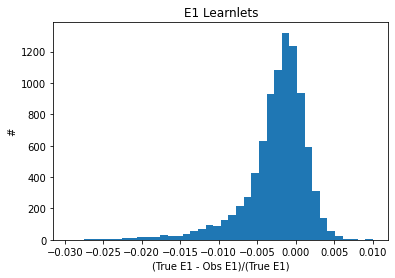

In [21]:
hist(diff_e1_HSM, bins=40)
pyplot.title('E1 Learnlets')
plt.ylabel("#")
plt.xlabel("(True E1 - Obs E1)/(True E1)")
plt.savefig("e1_learnlets.png")

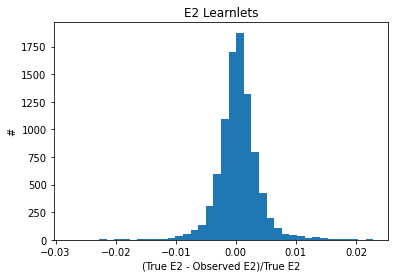

In [22]:
hist(diff_e2_HSM, bins=40)
pyplot.title('E2 Learnlets')
plt.ylabel("#")
plt.xlabel("(True E2 - Observed E2)/True E2")
plt.savefig("e2_learnlets.png")

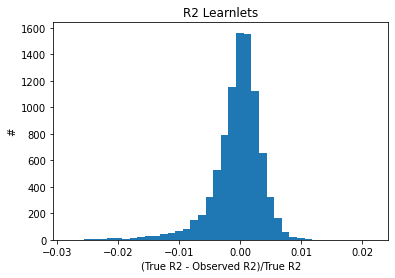

In [23]:
hist(-diff_R2_HSM/R2_HSM_true, bins=40)
pyplot.title('R2 Learnlets')
plt.ylabel("#")
plt.xlabel("(True R2 - Observed R2)/True R2")
plt.savefig("R2_learnlets.png")

In [24]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(e1_HSM_measured, e1_HSM_true, squared=False))
print(mean_squared_error(e2_HSM_measured, e2_HSM_true, squared=False))
print(mean_squared_error(R2_HSM_measured, R2_HSM_true, squared=False))

0.004846855636393201
0.0034804046346876283
0.006695871883278836


In [25]:
print(mean(diff_e1_HSM))
print(mean(diff_e2_HSM))
print(mean(diff_R2_HSM))

-0.0025013116376729583
0.0004055609326938875
0.00037625471750895185


In [12]:
model.save('training_learnlets/saved_learnlets.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

1/1 [==============================] - 7s 7s/step - loss: 1.1195e-05 - keras_psnr: 49.8497 - keras_ssim: 0.9443 - center_keras_psnr: 47.7540 - val_loss: 1.0421e-05 - val_keras_psnr: 50.2230 - val_keras_ssim: 0.9487 - val_center_keras_psnr: 48.1441


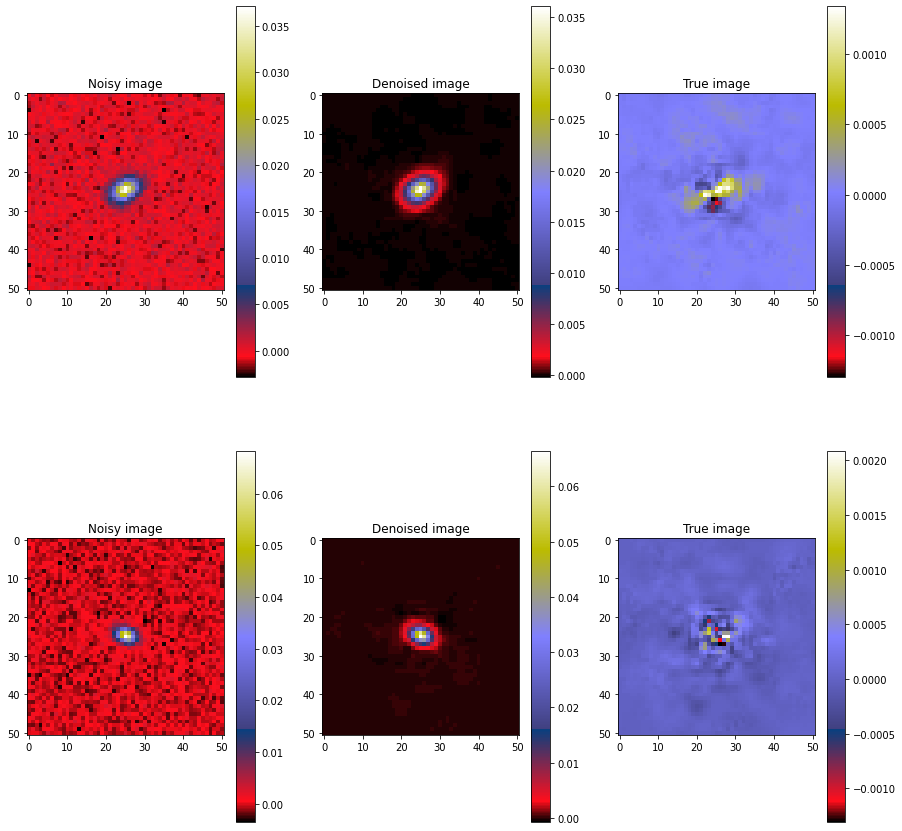

In [28]:
one_star_noiseless = tf.reshape(model1.predict((im_val, std_val))[0,:,:], [51, 51])
one_star_truth = tf.reshape(tf.convert_to_tensor(target_val[0,:,:]), [51, 51])
one_star_noiseless = tf.cast(one_star_noiseless, one_star_truth.dtype)
one_star_noise = tf.reshape(tf.convert_to_tensor(im_val[0,:,:]), [51, 51])
second_star_noiseless = tf.reshape(model1.predict((im_val, std_val))[8500,:,:], [51, 51])
second_star_truth = tf.reshape(tf.convert_to_tensor(target_val[8500,:,:]), [51, 51])
second_star_noiseless = tf.cast(second_star_noiseless, second_star_truth.dtype)
second_star_noise = tf.reshape(tf.convert_to_tensor(im_val[8500,:,:]), [51, 51])



fig = plt.figure(num=0, figsize=(15,15))
subplot(231)
title('Noisy image')
imshow(one_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(232)
#imshow(one_star_noiseless-one_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(233)
imshow(one_star_truth-one_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('True image')
subplot(234)
title('Noisy image')
imshow(second_star_noise, interpolation='None',cmap='gist_stern');colorbar()
subplot(235)
#imshow(second_star_noiseless-second_star_truth, interpolation='None',cmap='gist_stern');colorbar()
imshow(second_star_noiseless, interpolation='None',cmap='gist_stern');colorbar()
title('Denoised image')
subplot(236)
imshow(second_star_truth-second_star_noiseless, interpolation='None', cmap='gist_stern');colorbar()
title('True image')
show()

In [12]:
## Using Learnlet instead of learnlet
run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 64, 
        'mixing_details': False,    
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}

model=Learnlet(**run_params)
model.compile(optimizer=Adam(lr=1e-3),
    loss='mse',
    metrics=[keras_psnr, keras_ssim, center_keras_psnr],
)

im_train = tf.convert_to_tensor(np.random.randn(51,51,1))

history = model.fit(
    (im_train, 0), 
    im_train,
    validation_data=((im_train, 0), im_train),
    steps_per_epoch=200, 
    epochs=1,
    batch_size=12,
)

UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/low_pass_filtering_8/Conv2D (defined at /local/home/oa265351/denoising/learnlets/learnlet_layers.py:69) ]]
	 [[learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/fixed_point_pooling_14/strided_slice_2-0-1-TransposeNCHWToNHWC-LayoutOptimizer/_26]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/low_pass_filtering_8/Conv2D (defined at /local/home/oa265351/denoising/learnlets/learnlet_layers.py:69) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7267]

Errors may have originated from an input operation.
Input Source operations connected to node learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/low_pass_filtering_8/Conv2D:
 learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/MirrorPad (defined at /local/home/oa265351/denoising/learnlets/learnlet_layers.py:68)

Input Source operations connected to node learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/low_pass_filtering_8/Conv2D:
 learnlet_7/learnlet_analysis_7/wav_analysis_7/wav_pooling_7/MirrorPad (defined at /local/home/oa265351/denoising/learnlets/learnlet_layers.py:68)

Function call stack:
train_function -> train_function


In [3]:
im_train = tf.convert_to_tensor(np.random.randn(51,51,1))

In [16]:
im_train

array([[[ 9.78140270e-06,  1.35861104e-04,  2.09215475e-04, ...,
          4.14659844e-05,  2.25601209e-04,  3.05802503e-04],
        [ 9.73462011e-05,  4.43367695e-04,  1.52359862e-04, ...,
         -4.45220248e-05, -1.91409286e-04,  3.47580499e-05],
        [-4.88056103e-05, -4.29785228e-04, -4.14655631e-04, ...,
         -1.67280261e-04,  1.77023350e-04,  4.27776657e-04],
        ...,
        [ 1.54002424e-04, -1.77065856e-04,  2.20200745e-04, ...,
         -2.81989516e-04, -1.94253284e-04,  1.73627734e-04],
        [-5.41214598e-04,  2.96786078e-04, -8.39133572e-05, ...,
          5.74981619e-04,  1.24990602e-05,  4.09939297e-04],
        [-3.73433169e-04,  3.66013061e-04, -6.45330292e-05, ...,
         -4.81723924e-04, -2.05353805e-04,  4.67041013e-04]],

       [[-1.14939881e-04, -4.68709710e-04,  7.48977414e-04, ...,
          2.28098594e-04, -7.74882719e-05, -2.70254659e-05],
        [-1.41236203e-04,  1.98593421e-04, -3.45363835e-04, ...,
          1.48706255e-04, -3.71554343e